C:\Users\deepa\AppData\Local\Temp\ipykernel_13784\788777779.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()
C:\Users\deepa\AppData\Local\Temp\ipykernel_13784\788777779.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly['Volume'] = df.resample('M')['Volume'].sum()
c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\deepa\AppData\Local\Temp\ipykernel_13784\788777779.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Mean Squared Error (MSE): 3083322216.5789866
Mean Absolute Error (MAE): 51388.585462536794
Root Mean Squared Error (RMSE): 55527.670728916644
Mean Absolute Percentage Error (MAPE): 158.08886781039013
Symmetric Mean Absolute Percentage Error (sMAPE): 82.99398598618585
Mean Absolute Scaled Error (MASE): 15.32378279764736
R-squared: -10.354853894094799
Theil’s U: 0.4153486665879914
Coverage Probability (95% prediction interval): 1.0


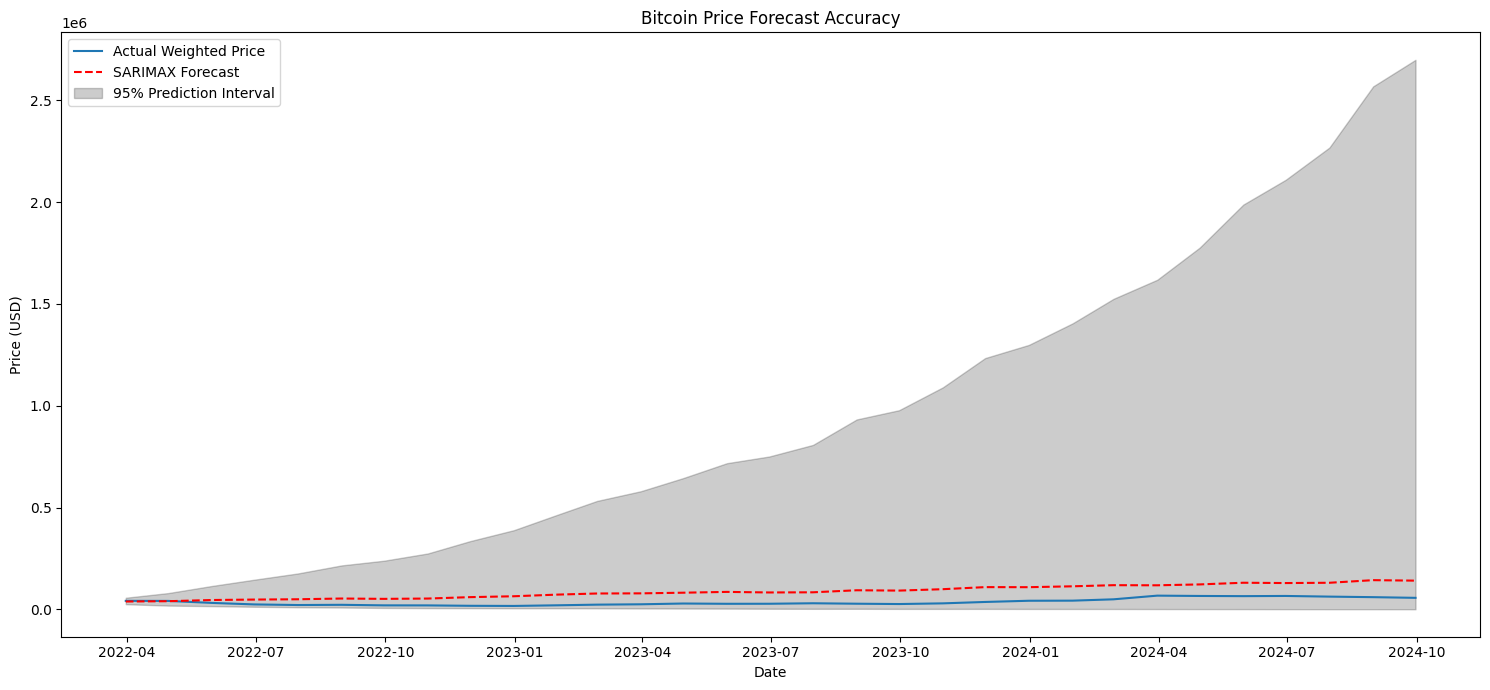

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import boxcox
from datetime import datetime

# Load the dataset
df = pd.read_csv('./btcusd_1-min_data.csv')

# Calculate the weighted price as the average of High, Low, and Close
if 'High' in df.columns and 'Low' in df.columns and 'Close' in df.columns:
    df['weighted_price'] = (df['High'] + df['Low'] + df['Close']) / 3
else:
    print("Required columns ('High', 'Low', 'Close') not found in the dataset.")

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Resample to monthly frequency and compute mean values
df_monthly = df.resample('M').mean()

# Drop missing values
df_monthly = df_monthly.dropna()

# Perform Box-Cox transformation on weighted_price using scipy's boxcox
df_monthly['weighted_price_box'], lmbda = boxcox(df_monthly['weighted_price'])

# Use the correct column for volume (replace with the actual column name)
df_monthly['Volume'] = df.resample('M')['Volume'].sum()

# Split data into training and testing sets for backtesting
train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly[:train_size], df_monthly[train_size:]

# SARIMAX model with exogenous variable (volume)
sarimax_model = sm.tsa.statespace.SARIMAX(train['weighted_price_box'], 
                                          order=(1, 1, 1), 
                                          seasonal_order=(1, 1, 1, 12), 
                                          exog=train[['Volume']])
sarimax_fit = sarimax_model.fit(disp=False)

# Predict on the test set
sarimax_forecast = sarimax_fit.get_forecast(steps=len(test), exog=test[['Volume']])

# Inverse Box-Cox transformation
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

test['sarimax_forecast'] = invboxcox(sarimax_forecast.predicted_mean, lmbda)

# Calculate forecast accuracy metrics

# Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE)
mse = mean_squared_error(test['weighted_price'], test['sarimax_forecast'])
mae = mean_absolute_error(test['weighted_price'], test['sarimax_forecast'])
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test['weighted_price'], test['sarimax_forecast'])

# Symmetric Mean Absolute Percentage Error (sMAPE)
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape_value = smape(test['weighted_price'], test['sarimax_forecast'])

# Mean Absolute Scaled Error (MASE)
def mase(y_true, y_pred):
    naive_error = np.mean(np.abs(np.diff(y_true)))  # Naive forecast error
    return np.mean(np.abs(y_true - y_pred)) / naive_error

mase_value = mase(test['weighted_price'], test['sarimax_forecast'])

# R-squared (Coefficient of Determination)
r_squared = 1 - (np.sum((test['weighted_price'] - test['sarimax_forecast']) ** 2) / np.sum((test['weighted_price'] - np.mean(test['weighted_price'])) ** 2))

# Theil's U Statistic
def theils_u(y_true, y_pred):
    numerator = np.sqrt(np.sum((y_pred - y_true) ** 2))
    denominator = np.sqrt(np.sum(y_true ** 2)) + np.sqrt(np.sum(y_pred ** 2))
    return numerator / denominator

theils_u_value = theils_u(test['weighted_price'], test['sarimax_forecast'])

# Prediction intervals (95% confidence intervals)
pred_int = sarimax_forecast.conf_int()

# Coverage Probability (95% Prediction Interval)
def coverage_probability(y_true, lower_bound, upper_bound):
    within_interval = np.where((y_true >= lower_bound) & (y_true <= upper_bound), 1, 0)
    return np.mean(within_interval)

lower_pred_int = invboxcox(pred_int.iloc[:, 0], lmbda)
upper_pred_int = invboxcox(pred_int.iloc[:, 1], lmbda)
coverage_prob = coverage_probability(test['weighted_price'], lower_pred_int, upper_pred_int)

# Print forecast accuracy metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Symmetric Mean Absolute Percentage Error (sMAPE): {smape_value}')
print(f'Mean Absolute Scaled Error (MASE): {mase_value}')
print(f'R-squared: {r_squared}')
print(f'Theil’s U: {theils_u_value}')
print(f'Coverage Probability (95% prediction interval): {coverage_prob}')

# Plot actual vs predicted with prediction intervals
plt.figure(figsize=(15, 7))

# Plot actual and predicted values
plt.plot(test.index, test['weighted_price'], label='Actual Weighted Price')
plt.plot(test.index, test['sarimax_forecast'], label='SARIMAX Forecast', color='red', linestyle='--')
plt.fill_between(test.index, lower_pred_int, upper_pred_int, color='k', alpha=0.2, label='95% Prediction Interval')

plt.title('Bitcoin Price Forecast Accuracy')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()
